# Entrenamiento para clasificación de imagenes

## Dataset

### Osteosarcoma-Tumor-Assessment
[Osteosarcoma data from UT Southwestern/UT Dallas for Viable and Necrotic Tumor Assessment](https://www.cancerimagingarchive.net/collection/osteosarcoma-tumor-assessment/)

> Leavey, P., Sengupta, A., Rakheja, D., Daescu, O., Arunachalam, H. B., & Mishra, R. (2019). Osteosarcoma data from UT Southwestern/UT Dallas for Viable and Necrotic Tumor Assessment (Osteosarcoma-Tumor-Assessment) [Data set]. The Cancer Imaging Archive. https://doi.org/10.7937/tcia.2019.bvhjhdas

#### Summary

Osteosarcoma is the most common type of bone cancer that occurs in adolescents in the age of 10 to 14 years. The dataset is composed of Hematoxylin and eosin (H&E) stained osteosarcoma histology images. The data was collected by a team of clinical scientists at University of Texas Southwestern Medical Center, Dallas. Archival samples for 50 patients treated at Children’ s Medical Center, Dallas, between 1995 and 2015, were used to create this dataset. Four patients (out of 50) were selected by pathologists based on diversity of tumor specimens after surgical resection. The images are labelled as Non-Tumor, Viable Tumor and Necrosis according to the predominant cancer type in each image. The annotation was performed by two medical experts. All images were divided between two pathologists for the annotation activity. Each image had a single annotation as any given image was annotated by only one pathologist. The dataset consists of 1144 images of size 1024 X 1024 at 10X resolution with the following distribution: 536 (47%) non-tumor images, 263 (23%) necrotic tumor images and 345 (30%) viable tumor tiles.

## Conversión a formato de YOLO

El dataset tiene una estructura distinta, que necesitamos cambiar a lo que espera YOLO.

Se asumple la carpeta `data/PKG - Osteosarcoma Tumor Assessment`

In [1]:
import os
import shutil
import pandas as pd

# Definir rutas
base_dir = "../data/PKG - Osteosarcoma Tumor Assessment"
output_dir = os.path.join(base_dir, "restructured")
output_csv = os.path.join(output_dir, "data.csv")

# Crear la carpeta restructured si no existe
os.makedirs(output_dir, exist_ok=True)

# Lista para almacenar los datos de los CSV
csv_data = []

# Recorrer Training-Set-1 y Training-Set-2
for training_set in ["Training-Set-1", "Training-Set-2"]:
    training_path = os.path.join(base_dir, training_set)
    
    # Recorrer las subcarpetas set1, set2, ..., set10
    for set_folder in os.listdir(training_path):
        set_path = os.path.join(training_path, set_folder)
        
        if os.path.isdir(set_path):  # Asegurarse de que es una carpeta
            csv_file = os.path.join(set_path, "PathologistValidation.csv")

            # Si existe el archivo PathologistValidation.csv, procesarlo
            if os.path.exists(csv_file):
                df = pd.read_csv(csv_file, header=None, names=["filename", "label"])
                df["original_set"] = training_set  # Agregar columna de set de origen
                df["original_folder"] = set_folder  # Agregar columna con set específico
                csv_data.append(df)

            # Mover imágenes a la nueva carpeta
            for img_file in os.listdir(set_path):
                img_path = os.path.join(set_path, img_file)
                if img_file.endswith((".jpg", ".png", ".jpeg")) and os.path.isfile(img_path):
                    new_img_path = os.path.join(output_dir, img_file)

                    # Evitar colisión de nombres agregando un prefijo si es necesario
                    counter = 1
                    while os.path.exists(new_img_path):
                        name, ext = os.path.splitext(img_file)
                        new_img_path = os.path.join(output_dir, f"{name}_{counter}{ext}")
                        counter += 1

                    shutil.copy2(img_path, new_img_path)

# Consolidar los CSV en un solo archivo
if csv_data:
    consolidated_df = pd.concat(csv_data, ignore_index=True)
    consolidated_df.to_csv(output_csv, index=False)

print(f"Proceso completado. Imágenes movidas a {output_dir} y CSV consolidado en {output_csv}.")

Proceso completado. Imágenes movidas a ../data/PKG - Osteosarcoma Tumor Assessment/restructured y CSV consolidado en ../data/PKG - Osteosarcoma Tumor Assessment/restructured/data.csv.


Para analizar los datos y verificar si hay archivos duplicados, podemos hacer lo siguiente:  

### Análisis a realizar:  
1. Contar el total de registros en `data.csv`  
2. Contar los archivos únicos en la columna de nombres de archivo.  
3. Contar la distribución de etiquetas (`Non-Tumor`, `Non-Viable-Tumor`, `Viable`, `Otros`) y compararla con la referencia.  
4. Buscar duplicados en la columna de nombres de archivo.  


### Explicación de los resultados:  
- Si `total_records` es mayor que 1145, significa que hay imágenes repetidas en `data.csv`.  
- Si `unique_files < 1145`, entonces faltan imágenes y habría que revisar qué pasó.  
- La distribución de etiquetas (`label_counts`) debe ser cercana a:  
  - `536 Non-Tumor`
  - `263 Non-Viable-Tumor`
  - `345 Viable`  
- Si `duplicates` no está vacío, hay imágenes con múltiples anotaciones (`viable: non-viable` podría estar causando problemas).  

---

### Próximos pasos según los resultados:
- Si hay archivos duplicados con múltiples etiquetas, podríamos decidir qué hacer con ellos (ej. elegir la etiqueta más frecuente o eliminarlos).  
- Si hay más de 1145 registros en `data.csv`, eliminar registros repetidos y guardar un nuevo CSV limpio.  
- Si hay menos de 1145 imágenes únicas, revisar qué imágenes faltan.  

### Generacion de un nuevo data.csv filtrado y sin repetidos

Si hemos confirmado que los labels repetidos contienen la misma información, y existe una etiqueta "zannotated" que no contiene una referencia a un nombre de archivo, podemos sobreescribir nuestros datos omitiendo los valores repetidos y la etiqueta sobrante.

In [2]:
import pandas as pd

# Cargar el archivo CSV consolidado
csv_path = output_csv
df = pd.read_csv(csv_path)

# Ver el total de registros
total_records = len(df)

# Contar archivos únicos
unique_files = df["filename"].nunique()

# Contar la distribución de etiquetas
label_counts = df["label"].value_counts()

# Verificar si hay archivos duplicados (mismo nombre de archivo con diferentes etiquetas)
duplicates = df[df.duplicated(subset=["filename"], keep=False)]

# Imprimir resultados
print(f"Total de registros en data.csv: {total_records}")
print(f"Total de archivos únicos: {unique_files}")
print("\nDistribución de etiquetas en data.csv:")
print(label_counts)

# Si hay duplicados, mostrarlos
if not duplicates.empty:
    print("\nArchivos con múltiples etiquetas:")
    print(duplicates)
    # Agrupar por filename y verificar si todas las etiquetas son iguales
    mismatched_labels = duplicates.groupby("filename")["label"].nunique()

    # Filtrar solo aquellos que tienen más de un label diferente
    conflicting_labels = mismatched_labels[mismatched_labels > 1]

    # Imprimir resultados
    if not conflicting_labels.empty:
        print("Archivos con etiquetas diferentes:")
        print(df[df["filename"].isin(conflicting_labels.index)])
        raise AttributeError("Las etiquetas para cada archivo repetido deben ser las mismas. Resuelve los conflictos antes de continuar")
    else:
        print("Todos los archivos duplicados tienen el mismo label.")

        # Eliminar la fila con "zannotated" en la columna de nombres de archivo
        df_cleaned = df[df["filename"] != "zannotated"]

        # Eliminar duplicados manteniendo la primera aparición
        df_cleaned = df_cleaned.drop_duplicates(subset=["filename"], keep="first")

        # Guardar el archivo limpio
        df_cleaned.to_csv(output_csv, index=False)

        print(f"Nuevo archivo limpio guardado en: {output_csv}")
        print(f"Total de filas después de limpieza: {len(df_cleaned)}")
else:
    print("\nNo hay archivos con etiquetas duplicadas.")

Total de registros en data.csv: 1406
Total de archivos únicos: 1145

Distribución de etiquetas en data.csv:
label
Non-Tumor             641
Viable                365
Non-Viable-Tumor      339
viable: non-viable     61
Name: count, dtype: int64

Archivos con múltiples etiquetas:
                              filename      label    original_set  \
99    Case 48 - P5 C19-51505-17925.jpg     Viable  Training-Set-1   
100   Case 48 - P5 C20-46837-16405.jpg     Viable  Training-Set-1   
101   Case 48 - P5 C19-41884-18067.jpg     Viable  Training-Set-1   
102    Case 48 - P5 C21-48446-3802.jpg     Viable  Training-Set-1   
103   Case 48 - P5 C19-51520-22044.jpg     Viable  Training-Set-1   
...                                ...        ...             ...   
1180                        zannotated  Non-Tumor  Training-Set-2   
1231                        zannotated  Non-Tumor  Training-Set-2   
1281                        zannotated  Non-Tumor  Training-Set-2   
1334                        zan

### Confirmación de la distribución de datos

De acuerdo a la información del dataset deberíamos tener:
> "536 (47%) non-tumor images, 263 (23%) necrotic tumor images and 345 (30%) viable tumor tiles."

- 536 Non-Tumor
- 345 Viable-Tumor
- 263 Necrotic-Tumor

Sin embargo, la notación de los archivos no es consistente con esto por lo que también debemos transformar los datos no debidamente identificados a nuestras clases.

Observando nuestro nuevo `data.csv` tenemos:

In [3]:
# Cargar el archivo CSV consolidado
csv_path = output_csv
df = pd.read_csv(csv_path)

# Ver el total de registros
total_records = len(df)

# Contar la distribución de etiquetas
label_counts = df["label"].value_counts()


# Imprimir resultados
print(f"Total de registros en data.csv: {total_records}")
print("\nDistribución de etiquetas en data.csv:")
print(label_counts)

Total de registros en data.csv: 1144

Distribución de etiquetas en data.csv:
label
Non-Tumor             536
Viable                292
Non-Viable-Tumor      263
viable: non-viable     53
Name: count, dtype: int64


Dado que existe únicamente una diferencia entre `Viable` y tenemos esos valores en la etiqueta `viable: non-viable` asumiremos que pertenecen a esa clase. De igual manera, tomaremos `Non-Viable-Tumor` como `Necrotic`. Sin embargo, esto es ambiguo y debería corregirse en el dataset original. 


In [4]:
# Cargar el archivo CSV
df = pd.read_csv(csv_path)

# Reemplazar etiquetas incorrectas por las correctas
df["label"] = df["label"].replace({
    "viable: non-viable": "Viable-Tumor",
    "Viable": "Viable-Tumor",
    "Non-Viable-Tumor": "Necrotic-Tumor"
})

# Limpiar los nombres de archivos (reemplazar secuencias de espacios o guiones con un solo guion)
df['filename'] = df['filename'].str.replace(r'[\s-]+', '-', regex=True)


# Guardar la versión final del CSV limpio
df.to_csv(output_csv, index=False)
print("Etiquetas corregidas y archivo actualizado.")

# Ver el total de registros
total_records = len(df)

# Contar la distribución de etiquetas
label_counts = df["label"].value_counts()


# Imprimir resultados
print(f"Total de registros en data.csv: {total_records}")
print("\nDistribución de etiquetas en data.csv:")
print(label_counts)

Etiquetas corregidas y archivo actualizado.
Total de registros en data.csv: 1144

Distribución de etiquetas en data.csv:
label
Non-Tumor         536
Viable-Tumor      345
Necrotic-Tumor    263
Name: count, dtype: int64


### Separación en formato para YOLO

Ahora si, podemos usar esta información para crear nuestro dataset para YOLO. Separado en carpetas siguiendo el formato
  - osteosarcoma2019
    - train
      - Non-Tumor
      - Viable-Tumor
      - Necrotic-Tumor
    - test
      - ...
    - val
      - ...

Usaremos una división estratificada para asegurar que cada conjunto tenga una proporción similar a la original de cada clase

In [32]:
import os
import pandas as pd
import shutil

# Definir rutas
base_dir = "../data/PKG - Osteosarcoma Tumor Assessment"
output_dir = os.path.join(base_dir, "restructured")
data_csv = os.path.join(output_dir, "data.csv")
osteosarcoma_dir = "../data/osteosarcoma2019"

# Crear la estructura de carpetas
subfolders = ['train', 'test', 'val']
categories = ['Non-Tumor', 'Viable-Tumor', 'Necrotic-Tumor']

# Crear las carpetas principales
os.makedirs(osteosarcoma_dir, exist_ok=True)
for folder in subfolders:
    for category in categories:
        os.makedirs(os.path.join(osteosarcoma_dir, folder, category), exist_ok=True)

# Leer el archivo CSV
df = pd.read_csv(data_csv, header=None, names=["filename", "label"], usecols=[0,1])

# Establecer el porcentaje de división
train_ratio = 0.8
val_ratio = 0.0
test_ratio = 0.2

# Función para dividir de forma estratificada
def stratified_split(df, train_ratio, val_ratio, test_ratio):
    # Dividir por clases
    train_data = pd.DataFrame()
    val_data = pd.DataFrame()
    test_data = pd.DataFrame()

    for category in categories:
        # Filtrar las imágenes por categoría
        category_data = df[df['label'] == category]
        
        # Calcular los índices para las divisiones
        total = len(category_data)
        train_size = int(total * train_ratio)
        val_size = int(total * val_ratio)
        test_size = total - train_size - val_size  # Resto para el tamaño de test

        # Dividir en partes
        category_train = category_data[:train_size]
        category_val = category_data[train_size:train_size + val_size]
        category_test = category_data[train_size + val_size:]

        # Agregar al DataFrame global
        train_data = pd.concat([train_data, category_train])
        val_data = pd.concat([val_data, category_val])
        test_data = pd.concat([test_data, category_test])

    return train_data, val_data, test_data

# Dividir los datos de forma estratificada
train_data, val_data, test_data = stratified_split(df, train_ratio, val_ratio, test_ratio)

# Función para mover los archivos
def move_files(data, category, target_folder):
    for _, row in data.iterrows():
        filename = row['filename']
        source_path = os.path.join(output_dir, filename)
        
        # Comprobar si el archivo existe
        if os.path.exists(source_path):
            destination_path = os.path.join(osteosarcoma_dir, target_folder, category, filename)
            shutil.copy(source_path, destination_path)

# Mover los archivos a las carpetas correspondientes
for category in categories:
    category_data = df[df['label'] == category]
    
    # Entrenamiento
    move_files(category_data[category_data.index.isin(train_data.index)], category, 'train')
    
    # Validación
    move_files(category_data[category_data.index.isin(val_data.index)], category, 'val')
    
    # Test
    move_files(category_data[category_data.index.isin(test_data.index)], category, 'test')

print("Archivos organizados y movidos correctamente.")


Archivos organizados y movidos correctamente.


## Entrenar red con YOLO

Ahora tenemos el dataset en un formato que YOLO si conoce, asi que podemos iniciar nuestro entrenamiento de clasificación

In [2]:
from ultralytics import YOLO
import os

# Ruta al checkpoint del mejor modelo
best_model_path = "../models/yolo/osteosarcoma2019/weights/best.pt"

# Cargar el modelo
if os.path.exists(best_model_path):
    model = YOLO(best_model_path) # Continuar desde checkpoint
else:
    model = YOLO("../data/osteosarcoma2019/yolo11s-cls.yaml")  # Cargar un nuevo modelo desde el archivo YAML

# Entrenamiento del modelo
results = model.train(
    pretrained=False, # NO usar los modelos preentrenados,
    resume=False,
    data="../data/osteosarcoma2019",  # Ruta al conjunto de datos
    epochs=200,  # Número de épocas
    imgsz=640,  # Tamaño de las imágenes
    batch=-1,
    project="../models/yolo",  # Directorio para los resultados del entrenamiento
    name="osteosarcoma2019",  # Nombre para la subcarpeta en 'project'
    plots=True, # Guardar graficas
    patience=50, # Detenerse si no hay cambios en n generaciones
    exist_ok=True, # Sobreescribir la carpeta
    multi_scale=True,  # Habilitar tamaños variables durante el entrenamiento
    val=False,
    device=0
)

# Los checkpoints del modelo (el mejor y el último) estarán en '../models/yolo/osteosarcoma/weights/'
# print(results)

New https://pypi.org/project/ultralytics/8.3.94 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.91 🚀 Python-3.12.7 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24089MiB)
engine/trainer: task=classify, mode=train, model=../models/yolo/osteosarcoma2019/weights/best.pt, data=../data/osteosarcoma2019, epochs=200, time=None, patience=50, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=../models/yolo, name=osteosarcoma2019, exist_ok=True, pretrained=False, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=False, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, c

train: Scanning /home/asdromundo/Documentos/classification/data/osteosarcoma2019/train... 914 images, 0 corrupt: 100%|██████████| 914/914 [00:00<?, ?it/s]
val: Scanning /home/asdromundo/Documentos/classification/data/osteosarcoma2019/test... 230 images, 0 corrupt: 100%|██████████| 230/230 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.00046875), 40 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to ../models/yolo/osteosarcoma2019
Starting training for 200 epochs...

      Epoch    GPU_mem       loss  Instances       Size


      1/200      3.55G     0.9449         14        640: 100%|██████████| 61/61 [00:05<00:00, 11.16it/s]



      Epoch    GPU_mem       loss  Instances       Size


      2/200      3.55G     0.8652         14        640: 100%|██████████| 61/61 [00:02<00:00, 23.24it/s]



      Epoch    GPU_mem       loss  Instances       Size


      3/200      3.56G     0.8783         14        640: 100%|██████████| 61/61 [00:03<00:00, 20.17it/s]



      Epoch    GPU_mem       loss  Instances       Size


      4/200      3.56G     0.7859         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.88it/s]



      Epoch    GPU_mem       loss  Instances       Size


      5/200      3.56G     0.6959         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.17it/s]



      Epoch    GPU_mem       loss  Instances       Size


      6/200      3.56G       0.69         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.02it/s]



      Epoch    GPU_mem       loss  Instances       Size


      7/200      3.56G     0.6657         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.20it/s]



      Epoch    GPU_mem       loss  Instances       Size


      8/200      3.56G     0.6965         14        640: 100%|██████████| 61/61 [00:02<00:00, 20.71it/s]



      Epoch    GPU_mem       loss  Instances       Size


      9/200      3.56G     0.5933         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.85it/s]



      Epoch    GPU_mem       loss  Instances       Size


     10/200      3.56G     0.6713         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.00it/s]



      Epoch    GPU_mem       loss  Instances       Size


     11/200      3.56G     0.6137         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.68it/s]



      Epoch    GPU_mem       loss  Instances       Size


     12/200      3.56G     0.5839         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.31it/s]



      Epoch    GPU_mem       loss  Instances       Size


     13/200      3.56G      0.616         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.94it/s]



      Epoch    GPU_mem       loss  Instances       Size


     14/200      3.56G      0.549         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.80it/s]



      Epoch    GPU_mem       loss  Instances       Size


     15/200      3.56G     0.5375         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.49it/s]



      Epoch    GPU_mem       loss  Instances       Size


     16/200      3.56G     0.4961         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.77it/s]



      Epoch    GPU_mem       loss  Instances       Size


     17/200      3.56G     0.5411         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.38it/s]



      Epoch    GPU_mem       loss  Instances       Size


     18/200      3.56G     0.5078         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.74it/s]



      Epoch    GPU_mem       loss  Instances       Size


     19/200      3.58G     0.4997         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.57it/s]



      Epoch    GPU_mem       loss  Instances       Size


     20/200       3.6G     0.4847         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.72it/s]



      Epoch    GPU_mem       loss  Instances       Size


     21/200      3.62G     0.5129         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.71it/s]



      Epoch    GPU_mem       loss  Instances       Size


     22/200      3.62G     0.5078         14        640: 100%|██████████| 61/61 [00:02<00:00, 20.79it/s]



      Epoch    GPU_mem       loss  Instances       Size


     23/200      3.62G     0.4726         14        640: 100%|██████████| 61/61 [00:02<00:00, 23.32it/s]



      Epoch    GPU_mem       loss  Instances       Size


     24/200      3.62G     0.4941         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.45it/s]



      Epoch    GPU_mem       loss  Instances       Size


     25/200      3.62G     0.4889         14        640: 100%|██████████| 61/61 [00:02<00:00, 20.61it/s]



      Epoch    GPU_mem       loss  Instances       Size


     26/200      3.62G     0.4283         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.46it/s]



      Epoch    GPU_mem       loss  Instances       Size


     27/200      3.62G     0.4313         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.41it/s]



      Epoch    GPU_mem       loss  Instances       Size


     28/200      3.62G     0.4886         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.59it/s]



      Epoch    GPU_mem       loss  Instances       Size


     29/200      3.62G     0.4343         14        640: 100%|██████████| 61/61 [00:02<00:00, 20.80it/s]



      Epoch    GPU_mem       loss  Instances       Size


     30/200      3.62G     0.4672         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.64it/s]



      Epoch    GPU_mem       loss  Instances       Size


     31/200      3.62G     0.4795         14        640: 100%|██████████| 61/61 [00:02<00:00, 20.92it/s]



      Epoch    GPU_mem       loss  Instances       Size


     32/200      3.62G     0.3987         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.55it/s]



      Epoch    GPU_mem       loss  Instances       Size


     33/200      3.62G     0.4463         14        640: 100%|██████████| 61/61 [00:02<00:00, 20.66it/s]



      Epoch    GPU_mem       loss  Instances       Size


     34/200      3.63G     0.4299         14        640: 100%|██████████| 61/61 [00:02<00:00, 20.61it/s]



      Epoch    GPU_mem       loss  Instances       Size


     35/200      3.65G     0.4147         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.51it/s]



      Epoch    GPU_mem       loss  Instances       Size


     36/200      3.65G     0.4126         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.11it/s]



      Epoch    GPU_mem       loss  Instances       Size


     37/200      3.65G     0.4067         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.23it/s]



      Epoch    GPU_mem       loss  Instances       Size


     38/200      3.65G     0.3866         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.32it/s]



      Epoch    GPU_mem       loss  Instances       Size


     39/200      3.65G      0.388         14        640: 100%|██████████| 61/61 [00:02<00:00, 23.01it/s]



      Epoch    GPU_mem       loss  Instances       Size


     40/200      3.65G     0.3764         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.72it/s]



      Epoch    GPU_mem       loss  Instances       Size


     41/200      3.65G     0.3901         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.90it/s]



      Epoch    GPU_mem       loss  Instances       Size


     42/200      3.65G     0.4101         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.92it/s]



      Epoch    GPU_mem       loss  Instances       Size


     43/200      3.65G     0.3938         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.64it/s]



      Epoch    GPU_mem       loss  Instances       Size


     44/200      3.65G     0.4306         14        640: 100%|██████████| 61/61 [00:03<00:00, 20.21it/s]


      Epoch    GPU_mem       loss  Instances       Size



     45/200      3.65G     0.4217         14        640: 100%|██████████| 61/61 [00:02<00:00, 20.67it/s]



      Epoch    GPU_mem       loss  Instances       Size


     46/200      3.65G     0.4081         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.57it/s]



      Epoch    GPU_mem       loss  Instances       Size


     47/200      3.65G     0.3729         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.16it/s]



      Epoch    GPU_mem       loss  Instances       Size


     48/200      3.65G     0.3459         14        640: 100%|██████████| 61/61 [00:02<00:00, 20.42it/s]



      Epoch    GPU_mem       loss  Instances       Size


     49/200      3.65G     0.3829         14        640: 100%|██████████| 61/61 [00:03<00:00, 20.08it/s]



      Epoch    GPU_mem       loss  Instances       Size


     50/200      3.65G       0.38         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.29it/s]



      Epoch    GPU_mem       loss  Instances       Size


     51/200      3.65G     0.3747         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.44it/s]



      Epoch    GPU_mem       loss  Instances       Size


     52/200      3.65G     0.3841         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.49it/s]



      Epoch    GPU_mem       loss  Instances       Size


     53/200      3.65G     0.3875         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.80it/s]



      Epoch    GPU_mem       loss  Instances       Size


     54/200      3.65G     0.3765         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.56it/s]



      Epoch    GPU_mem       loss  Instances       Size


     55/200      3.65G     0.3601         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.08it/s]



      Epoch    GPU_mem       loss  Instances       Size


     56/200      3.65G     0.4517         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.84it/s]



      Epoch    GPU_mem       loss  Instances       Size


     57/200      3.65G     0.3955         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.30it/s]



      Epoch    GPU_mem       loss  Instances       Size


     58/200      3.65G     0.3798         14        640: 100%|██████████| 61/61 [00:03<00:00, 19.68it/s]



      Epoch    GPU_mem       loss  Instances       Size


     59/200      3.65G     0.3923         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.84it/s]



      Epoch    GPU_mem       loss  Instances       Size


     60/200      3.65G     0.3667         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.34it/s]



      Epoch    GPU_mem       loss  Instances       Size


     61/200      3.65G     0.3673         14        640: 100%|██████████| 61/61 [00:02<00:00, 20.90it/s]



      Epoch    GPU_mem       loss  Instances       Size


     62/200      3.65G      0.363         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.41it/s]



      Epoch    GPU_mem       loss  Instances       Size


     63/200      3.65G     0.3799         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.59it/s]



      Epoch    GPU_mem       loss  Instances       Size


     64/200      3.65G     0.3819         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.00it/s]



      Epoch    GPU_mem       loss  Instances       Size


     65/200      3.65G     0.3742         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.92it/s]



      Epoch    GPU_mem       loss  Instances       Size


     66/200      3.65G      0.353         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.44it/s]



      Epoch    GPU_mem       loss  Instances       Size


     67/200      3.65G     0.3549         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.24it/s]



      Epoch    GPU_mem       loss  Instances       Size


     68/200      3.65G     0.3684         14        640: 100%|██████████| 61/61 [00:03<00:00, 20.01it/s]



      Epoch    GPU_mem       loss  Instances       Size


     69/200      3.65G     0.3506         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.48it/s]


      Epoch    GPU_mem       loss  Instances       Size



     70/200      3.65G     0.3188         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.72it/s]



      Epoch    GPU_mem       loss  Instances       Size


     71/200      3.65G     0.3522         14        640: 100%|██████████| 61/61 [00:02<00:00, 20.94it/s]



      Epoch    GPU_mem       loss  Instances       Size


     72/200      3.65G     0.3838         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.65it/s]



      Epoch    GPU_mem       loss  Instances       Size


     73/200      3.65G     0.3705         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.24it/s]



      Epoch    GPU_mem       loss  Instances       Size


     74/200      3.65G     0.3541         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.62it/s]



      Epoch    GPU_mem       loss  Instances       Size


     75/200      3.65G     0.3357         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.40it/s]



      Epoch    GPU_mem       loss  Instances       Size


     76/200      3.65G     0.3353         14        640: 100%|██████████| 61/61 [00:02<00:00, 20.59it/s]



      Epoch    GPU_mem       loss  Instances       Size


     77/200      3.65G     0.3469         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.58it/s]



      Epoch    GPU_mem       loss  Instances       Size


     78/200      3.65G     0.3396         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.28it/s]



      Epoch    GPU_mem       loss  Instances       Size


     79/200      3.65G     0.3465         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.52it/s]



      Epoch    GPU_mem       loss  Instances       Size


     80/200      3.65G      0.358         14        640: 100%|██████████| 61/61 [00:02<00:00, 23.09it/s]



      Epoch    GPU_mem       loss  Instances       Size


     81/200      3.65G     0.3444         14        640: 100%|██████████| 61/61 [00:03<00:00, 19.92it/s]



      Epoch    GPU_mem       loss  Instances       Size


     82/200      3.65G       0.33         14        640: 100%|██████████| 61/61 [00:02<00:00, 20.96it/s]



      Epoch    GPU_mem       loss  Instances       Size


     83/200      3.65G      0.312         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.47it/s]



      Epoch    GPU_mem       loss  Instances       Size


     84/200      3.65G     0.3632         14        640: 100%|██████████| 61/61 [00:02<00:00, 20.93it/s]



      Epoch    GPU_mem       loss  Instances       Size


     85/200      3.65G     0.3432         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.74it/s]



      Epoch    GPU_mem       loss  Instances       Size


     86/200      3.65G     0.3209         14        640: 100%|██████████| 61/61 [00:03<00:00, 20.13it/s]



      Epoch    GPU_mem       loss  Instances       Size


     87/200      3.65G     0.3246         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.97it/s]



      Epoch    GPU_mem       loss  Instances       Size


     88/200      3.65G     0.2889         14        640: 100%|██████████| 61/61 [00:03<00:00, 20.21it/s]


      Epoch    GPU_mem       loss  Instances       Size



     89/200      3.65G     0.2926         14        640: 100%|██████████| 61/61 [00:02<00:00, 23.13it/s]



      Epoch    GPU_mem       loss  Instances       Size


     90/200      3.65G     0.2819         14        640: 100%|██████████| 61/61 [00:02<00:00, 23.00it/s]



      Epoch    GPU_mem       loss  Instances       Size


     91/200      3.65G     0.3421         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.57it/s]



      Epoch    GPU_mem       loss  Instances       Size


     92/200      3.65G     0.3466         14        640: 100%|██████████| 61/61 [00:03<00:00, 20.09it/s]



      Epoch    GPU_mem       loss  Instances       Size


     93/200      3.65G     0.3214         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.42it/s]



      Epoch    GPU_mem       loss  Instances       Size


     94/200      3.65G     0.3108         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.45it/s]



      Epoch    GPU_mem       loss  Instances       Size


     95/200      3.65G     0.3191         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.87it/s]



      Epoch    GPU_mem       loss  Instances       Size


     96/200      3.65G     0.2868         14        640: 100%|██████████| 61/61 [00:02<00:00, 24.21it/s]



      Epoch    GPU_mem       loss  Instances       Size


     97/200      3.65G     0.3382         14        640: 100%|██████████| 61/61 [00:02<00:00, 23.48it/s]



      Epoch    GPU_mem       loss  Instances       Size


     98/200      3.65G     0.2776         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.54it/s]



      Epoch    GPU_mem       loss  Instances       Size


     99/200      3.65G     0.3347         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.04it/s]



      Epoch    GPU_mem       loss  Instances       Size


    100/200      3.65G     0.3037         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.23it/s]



      Epoch    GPU_mem       loss  Instances       Size


    101/200      3.65G     0.3039         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.34it/s]



      Epoch    GPU_mem       loss  Instances       Size


    102/200      3.65G      0.324         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.77it/s]



      Epoch    GPU_mem       loss  Instances       Size


    103/200      3.65G     0.2825         14        640: 100%|██████████| 61/61 [00:02<00:00, 23.53it/s]



      Epoch    GPU_mem       loss  Instances       Size


    104/200      3.65G     0.3171         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.05it/s]



      Epoch    GPU_mem       loss  Instances       Size


    105/200      3.65G     0.2935         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.07it/s]



      Epoch    GPU_mem       loss  Instances       Size


    106/200      3.65G     0.3015         14        640: 100%|██████████| 61/61 [00:02<00:00, 20.86it/s]



      Epoch    GPU_mem       loss  Instances       Size


    107/200      3.65G     0.2816         14        640: 100%|██████████| 61/61 [00:02<00:00, 24.38it/s]



      Epoch    GPU_mem       loss  Instances       Size


    108/200      3.65G     0.3004         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.05it/s]



      Epoch    GPU_mem       loss  Instances       Size


    109/200      3.65G     0.2627         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.10it/s]



      Epoch    GPU_mem       loss  Instances       Size


    110/200      3.65G     0.2658         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.71it/s]



      Epoch    GPU_mem       loss  Instances       Size


    111/200      3.65G     0.2642         14        640: 100%|██████████| 61/61 [00:02<00:00, 24.07it/s]



      Epoch    GPU_mem       loss  Instances       Size


    112/200      3.65G     0.2904         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.90it/s]



      Epoch    GPU_mem       loss  Instances       Size


    113/200      3.65G     0.2522         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.28it/s]



      Epoch    GPU_mem       loss  Instances       Size


    114/200      3.65G     0.3115         14        640: 100%|██████████| 61/61 [00:02<00:00, 23.47it/s]



      Epoch    GPU_mem       loss  Instances       Size


    115/200      3.65G     0.2924         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.12it/s]



      Epoch    GPU_mem       loss  Instances       Size


    116/200      3.65G     0.2312         14        640: 100%|██████████| 61/61 [00:02<00:00, 23.80it/s]



      Epoch    GPU_mem       loss  Instances       Size


    117/200      3.65G      0.267         14        640: 100%|██████████| 61/61 [00:02<00:00, 23.25it/s]



      Epoch    GPU_mem       loss  Instances       Size


    118/200      3.65G     0.2786         14        640: 100%|██████████| 61/61 [00:02<00:00, 23.49it/s]



      Epoch    GPU_mem       loss  Instances       Size


    119/200      3.65G     0.2837         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.91it/s]



      Epoch    GPU_mem       loss  Instances       Size


    120/200      3.65G     0.2909         14        640: 100%|██████████| 61/61 [00:02<00:00, 24.08it/s]



      Epoch    GPU_mem       loss  Instances       Size


    121/200      3.65G     0.2703         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.72it/s]



      Epoch    GPU_mem       loss  Instances       Size


    122/200      3.65G     0.2693         14        640: 100%|██████████| 61/61 [00:02<00:00, 23.32it/s]



      Epoch    GPU_mem       loss  Instances       Size


    123/200      3.67G     0.2627         14        640: 100%|██████████| 61/61 [00:02<00:00, 23.24it/s]



      Epoch    GPU_mem       loss  Instances       Size


    124/200      3.67G     0.2745         14        640: 100%|██████████| 61/61 [00:02<00:00, 23.10it/s]



      Epoch    GPU_mem       loss  Instances       Size


    125/200      3.67G     0.2723         14        640: 100%|██████████| 61/61 [00:02<00:00, 24.04it/s]



      Epoch    GPU_mem       loss  Instances       Size


    126/200      3.67G     0.2602         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.18it/s]



      Epoch    GPU_mem       loss  Instances       Size


    127/200      3.67G     0.3031         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.91it/s]



      Epoch    GPU_mem       loss  Instances       Size


    128/200      3.67G     0.2409         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.43it/s]



      Epoch    GPU_mem       loss  Instances       Size


    129/200      3.67G     0.2496         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.28it/s]



      Epoch    GPU_mem       loss  Instances       Size


    130/200      3.67G     0.2654         14        640: 100%|██████████| 61/61 [00:02<00:00, 20.80it/s]



      Epoch    GPU_mem       loss  Instances       Size


    131/200      3.67G     0.2686         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.79it/s]



      Epoch    GPU_mem       loss  Instances       Size


    132/200      3.67G     0.2746         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.63it/s]



      Epoch    GPU_mem       loss  Instances       Size


    133/200      3.67G     0.2723         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.68it/s]



      Epoch    GPU_mem       loss  Instances       Size


    134/200      3.67G     0.2391         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.22it/s]



      Epoch    GPU_mem       loss  Instances       Size


    135/200      3.67G     0.2698         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.83it/s]



      Epoch    GPU_mem       loss  Instances       Size


    136/200      3.67G     0.2202         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.27it/s]



      Epoch    GPU_mem       loss  Instances       Size


    137/200      3.67G     0.2576         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.10it/s]



      Epoch    GPU_mem       loss  Instances       Size


    138/200      3.67G     0.2499         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.66it/s]



      Epoch    GPU_mem       loss  Instances       Size


    139/200      3.67G     0.2652         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.78it/s]



      Epoch    GPU_mem       loss  Instances       Size


    140/200      3.67G     0.2301         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.17it/s]



      Epoch    GPU_mem       loss  Instances       Size


    141/200      3.67G     0.2536         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.41it/s]



      Epoch    GPU_mem       loss  Instances       Size


    142/200      3.67G     0.2269         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.45it/s]



      Epoch    GPU_mem       loss  Instances       Size


    143/200      3.67G     0.2322         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.32it/s]



      Epoch    GPU_mem       loss  Instances       Size


    144/200      3.67G     0.2311         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.92it/s]



      Epoch    GPU_mem       loss  Instances       Size


    145/200      3.67G     0.2313         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.26it/s]



      Epoch    GPU_mem       loss  Instances       Size


    146/200      3.67G     0.2364         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.95it/s]



      Epoch    GPU_mem       loss  Instances       Size


    147/200      3.67G     0.2659         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.40it/s]



      Epoch    GPU_mem       loss  Instances       Size


    148/200      3.67G     0.2505         14        640: 100%|██████████| 61/61 [00:02<00:00, 23.58it/s]



      Epoch    GPU_mem       loss  Instances       Size


    149/200      3.67G     0.2333         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.09it/s]



      Epoch    GPU_mem       loss  Instances       Size


    150/200      3.67G      0.232         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.73it/s]



      Epoch    GPU_mem       loss  Instances       Size


    151/200      3.67G     0.2488         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.84it/s]



      Epoch    GPU_mem       loss  Instances       Size


    152/200      3.67G     0.2504         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.49it/s]



      Epoch    GPU_mem       loss  Instances       Size


    153/200      3.67G     0.2307         14        640: 100%|██████████| 61/61 [00:02<00:00, 20.97it/s]



      Epoch    GPU_mem       loss  Instances       Size


    154/200      3.67G     0.2321         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.19it/s]



      Epoch    GPU_mem       loss  Instances       Size


    155/200      3.67G     0.2065         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.40it/s]



      Epoch    GPU_mem       loss  Instances       Size


    156/200      3.67G     0.2208         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.60it/s]



      Epoch    GPU_mem       loss  Instances       Size


    157/200      3.67G     0.1853         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.85it/s]



      Epoch    GPU_mem       loss  Instances       Size


    158/200      3.67G     0.2063         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.85it/s]



      Epoch    GPU_mem       loss  Instances       Size


    159/200      3.67G     0.2155         14        640: 100%|██████████| 61/61 [00:02<00:00, 23.41it/s]



      Epoch    GPU_mem       loss  Instances       Size


    160/200      3.67G     0.2268         14        640: 100%|██████████| 61/61 [00:02<00:00, 23.27it/s]



      Epoch    GPU_mem       loss  Instances       Size


    161/200      3.67G     0.2038         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.85it/s]



      Epoch    GPU_mem       loss  Instances       Size


    162/200      3.67G     0.2373         14        640: 100%|██████████| 61/61 [00:02<00:00, 23.27it/s]



      Epoch    GPU_mem       loss  Instances       Size


    163/200      3.67G     0.2053         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.20it/s]



      Epoch    GPU_mem       loss  Instances       Size


    164/200      3.67G     0.2224         14        640: 100%|██████████| 61/61 [00:02<00:00, 23.11it/s]



      Epoch    GPU_mem       loss  Instances       Size


    165/200      3.67G     0.2126         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.63it/s]



      Epoch    GPU_mem       loss  Instances       Size


    166/200      3.67G     0.2169         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.58it/s]



      Epoch    GPU_mem       loss  Instances       Size


    167/200      3.67G     0.2121         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.47it/s]



      Epoch    GPU_mem       loss  Instances       Size


    168/200      3.67G     0.2186         14        640: 100%|██████████| 61/61 [00:02<00:00, 23.56it/s]



      Epoch    GPU_mem       loss  Instances       Size


    169/200      3.67G     0.2075         14        640: 100%|██████████| 61/61 [00:02<00:00, 23.16it/s]



      Epoch    GPU_mem       loss  Instances       Size


    170/200      3.67G     0.1827         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.87it/s]



      Epoch    GPU_mem       loss  Instances       Size


    171/200      3.67G     0.2058         14        640: 100%|██████████| 61/61 [00:02<00:00, 23.67it/s]



      Epoch    GPU_mem       loss  Instances       Size


    172/200      3.67G     0.1964         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.99it/s]



      Epoch    GPU_mem       loss  Instances       Size


    173/200      3.67G     0.1925         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.63it/s]


      Epoch    GPU_mem       loss  Instances       Size



    174/200      3.67G     0.1969         14        640: 100%|██████████| 61/61 [00:02<00:00, 23.98it/s]



      Epoch    GPU_mem       loss  Instances       Size


    175/200      3.67G     0.2057         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.98it/s]



      Epoch    GPU_mem       loss  Instances       Size


    176/200      3.67G     0.1847         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.61it/s]



      Epoch    GPU_mem       loss  Instances       Size


    177/200      3.67G     0.1713         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.40it/s]


      Epoch    GPU_mem       loss  Instances       Size



    178/200      3.67G     0.1703         14        640: 100%|██████████| 61/61 [00:02<00:00, 24.04it/s]



      Epoch    GPU_mem       loss  Instances       Size


    179/200      3.67G     0.1931         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.98it/s]



      Epoch    GPU_mem       loss  Instances       Size


    180/200      3.67G      0.199         14        640: 100%|██████████| 61/61 [00:02<00:00, 21.70it/s]


      Epoch    GPU_mem       loss  Instances       Size



    181/200      3.67G      0.215         14        640: 100%|██████████| 61/61 [00:02<00:00, 23.40it/s]



      Epoch    GPU_mem       loss  Instances       Size


    182/200      3.67G     0.1934         14        640: 100%|██████████| 61/61 [00:02<00:00, 20.51it/s]



      Epoch    GPU_mem       loss  Instances       Size


    183/200      3.67G     0.1682         14        640: 100%|██████████| 61/61 [00:02<00:00, 24.00it/s]



      Epoch    GPU_mem       loss  Instances       Size


    184/200      3.67G     0.1883         14        640: 100%|██████████| 61/61 [00:02<00:00, 25.07it/s]



      Epoch    GPU_mem       loss  Instances       Size


    185/200      3.67G     0.2131         14        640: 100%|██████████| 61/61 [00:02<00:00, 24.10it/s]



      Epoch    GPU_mem       loss  Instances       Size


    186/200      3.67G     0.1761         14        640: 100%|██████████| 61/61 [00:02<00:00, 24.45it/s]



      Epoch    GPU_mem       loss  Instances       Size


    187/200      3.67G     0.1807         14        640: 100%|██████████| 61/61 [00:02<00:00, 24.26it/s]



      Epoch    GPU_mem       loss  Instances       Size


    188/200      3.67G      0.148         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.88it/s]


      Epoch    GPU_mem       loss  Instances       Size



    189/200      3.67G     0.1836         14        640: 100%|██████████| 61/61 [00:02<00:00, 24.85it/s]



      Epoch    GPU_mem       loss  Instances       Size


    190/200      3.67G     0.1808         14        640: 100%|██████████| 61/61 [00:02<00:00, 24.12it/s]



      Epoch    GPU_mem       loss  Instances       Size


    191/200       3.9G     0.1796         14        640: 100%|██████████| 61/61 [00:02<00:00, 20.46it/s]



      Epoch    GPU_mem       loss  Instances       Size


    192/200       3.9G     0.2258         14        640: 100%|██████████| 61/61 [00:02<00:00, 24.10it/s]



      Epoch    GPU_mem       loss  Instances       Size


    193/200       3.9G     0.1856         14        640: 100%|██████████| 61/61 [00:02<00:00, 24.89it/s]



      Epoch    GPU_mem       loss  Instances       Size


    194/200       3.9G     0.1692         14        640: 100%|██████████| 61/61 [00:02<00:00, 23.53it/s]



      Epoch    GPU_mem       loss  Instances       Size


    195/200       3.9G     0.1535         14        640: 100%|██████████| 61/61 [00:02<00:00, 22.75it/s]



      Epoch    GPU_mem       loss  Instances       Size


    196/200       3.9G     0.1873         14        640: 100%|██████████| 61/61 [00:02<00:00, 23.92it/s]



      Epoch    GPU_mem       loss  Instances       Size


    197/200       3.9G     0.1617         14        640: 100%|██████████| 61/61 [00:02<00:00, 24.71it/s]



      Epoch    GPU_mem       loss  Instances       Size


    198/200       3.9G     0.1624         14        640: 100%|██████████| 61/61 [00:02<00:00, 23.76it/s]



      Epoch    GPU_mem       loss  Instances       Size


    199/200       3.9G     0.1763         14        640: 100%|██████████| 61/61 [00:02<00:00, 24.27it/s]



      Epoch    GPU_mem       loss  Instances       Size


    200/200       3.9G     0.1862         14        640: 100%|██████████| 61/61 [00:02<00:00, 23.68it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 8/8 [00:00<00:00, 12.72it/s]


                   all        0.9          1

200 epochs completed in 0.164 hours.
Optimizer stripped from ../models/yolo/osteosarcoma2019/weights/last.pt, 11.0MB
Optimizer stripped from ../models/yolo/osteosarcoma2019/weights/best.pt, 11.0MB

Validating ../models/yolo/osteosarcoma2019/weights/best.pt...
Ultralytics 8.3.91 🚀 Python-3.12.7 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24089MiB)
YOLO11s-cls summary (fused): 47 layers, 5,437,971 parameters, 0 gradients, 12.0 GFLOPs
WARNING ⚠️ Dataset 'split=val' not found, using 'split=test' instead.
train: /home/asdromundo/Documentos/classification/data/osteosarcoma2019/train... found 914 images in 3 classes ✅ 
val: /home/asdromundo/Documentos/classification/data/osteosarcoma2019/test... found 230 images in 3 classes ✅ 
test: /home/asdromundo/Documentos/classification/data/osteosarcoma2019/test... found 230 images in 3 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 8/8 [00:00<00:00, 33.05it/s]


                   all        0.9          1
Speed: 0.3ms preprocess, 0.7ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to ../models/yolo/osteosarcoma2019


### Validación del mejor checkpoint

In [4]:
from ultralytics import YOLO

# Cargar el mejor checkpoint guardado
model = YOLO("../models/yolo/osteosarcoma2019/weights/best.pt") 

# Validar el modelo con los datos de prueba
metrics = model.val(data="../data/osteosarcoma2019",  # Ruta al archivo de configuración del dataset
                    imgsz=640,                      # Tamaño de las imágenes de entrada
                    batch=16,                       # Tamaño del batch
                    save_json=True,                 # Guardar los resultados en un archivo JSON
                    plots=True,                     # Generar y guardar gráficos                
                    split="test",
                    project="../models/yolo",  # Directorio para los resultados del entrenamiento
                    name="osteosarcoma2019",
                    exist_ok=True
                    )

Ultralytics 8.3.91 🚀 Python-3.12.7 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24089MiB)
YOLO11s-cls summary (fused): 47 layers, 5,437,971 parameters, 0 gradients, 12.0 GFLOPs
train: /home/asdromundo/Documentos/classification/data/osteosarcoma2019/train... found 914 images in 3 classes ✅ 
val: None...
test: /home/asdromundo/Documentos/classification/data/osteosarcoma2019/test... found 230 images in 3 classes ✅ 


test: Scanning /home/asdromundo/Documentos/classification/data/osteosarcoma2019/test... 230 images, 0 corrupt: 100%|██████████| 230/230 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 15/15 [00:00<00:00, 16.03it/s]


                   all        0.9          1
Speed: 0.8ms preprocess, 0.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to ../models/yolo/osteosarcoma2019


Ahora haremos un entrenamiento análogo con las demás redes de interés

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
import os

# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using: ", device)

# Liberar memoria en la GPU antes de comenzar
torch.cuda.empty_cache()

# Habilitar optimizaciones en GPUs NVIDIA
torch.backends.cudnn.benchmark = True

# Transformaciones (imagen 256x256 para reducir uso de memoria)
transform = EfficientNet_V2_S_Weights.IMAGENET1K_V1.transforms()

# Cargar el dataset
data_dir = "../data/osteosarcoma2019"
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "test"), transform=transform)

# DataLoaders con batch reducido y pin_memory para eficiencia
batch_size = 32  # Reducido para evitar OOM
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

# Cargar modelo EfficientNetV2 pequeño sin pesos preentrenados
model = efficientnet_v2_s(weights=None)
num_classes = len(train_dataset.classes)  # Número de clases
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)  # Ajustar salida
model = model.to(device)

# Definir función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Configurar AMP para entrenamiento en precisión mixta
scaler = torch.amp.GradScaler("cuda")

# Entrenamiento
num_epochs = 200
best_acc = 0.0
save_path = "../models/efficientnet/osteosarcoma2019/best_model.pth"
os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Crear directorios si no existen

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        
        with torch.amp.autocast("cuda"):  # Usar precisión mixta
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = 100. * correct / total

    # Validación
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with torch.amp.autocast("cuda"):  # También usar AMP en validación
                outputs = model(inputs)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    val_acc = 100. * correct / total

    print(f"Época {epoch+1}/{num_epochs}: Pérdida {train_loss:.4f} - Acc: {train_acc:.2f}% - Val Acc: {val_acc:.2f}%")

    # Guardar el mejor modelo
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), save_path)
        print("✅ Modelo mejorado guardado!")

print(f"🏆 Entrenamiento finalizado. Mejor precisión en validación: {best_acc:.2f}%")


Época 1/200: Pérdida 0.8999 - Acc: 60.39% - Val Acc: 30.00%
✅ Modelo mejorado guardado!
Época 2/200: Pérdida 0.5566 - Acc: 79.98% - Val Acc: 68.70%
✅ Modelo mejorado guardado!
Época 3/200: Pérdida 0.4651 - Acc: 83.15% - Val Acc: 81.30%
✅ Modelo mejorado guardado!
Época 4/200: Pérdida 0.5117 - Acc: 80.74% - Val Acc: 84.78%
✅ Modelo mejorado guardado!
Época 5/200: Pérdida 0.4137 - Acc: 84.90% - Val Acc: 87.39%
✅ Modelo mejorado guardado!
Época 6/200: Pérdida 0.3985 - Acc: 84.90% - Val Acc: 77.83%
Época 7/200: Pérdida 0.3724 - Acc: 87.75% - Val Acc: 82.61%
Época 8/200: Pérdida 0.4401 - Acc: 85.45% - Val Acc: 81.74%
Época 9/200: Pérdida 0.3511 - Acc: 87.42% - Val Acc: 83.04%
Época 10/200: Pérdida 0.3271 - Acc: 88.51% - Val Acc: 89.13%
✅ Modelo mejorado guardado!
Época 11/200: Pérdida 0.3794 - Acc: 86.87% - Val Acc: 86.52%
Época 12/200: Pérdida 0.3455 - Acc: 88.29% - Val Acc: 87.83%
Época 13/200: Pérdida 0.3212 - Acc: 88.40% - Val Acc: 88.70%
Época 14/200: Pérdida 0.3140 - Acc: 87.86% - Val

KeyboardInterrupt: 

### Probando EfficientNet

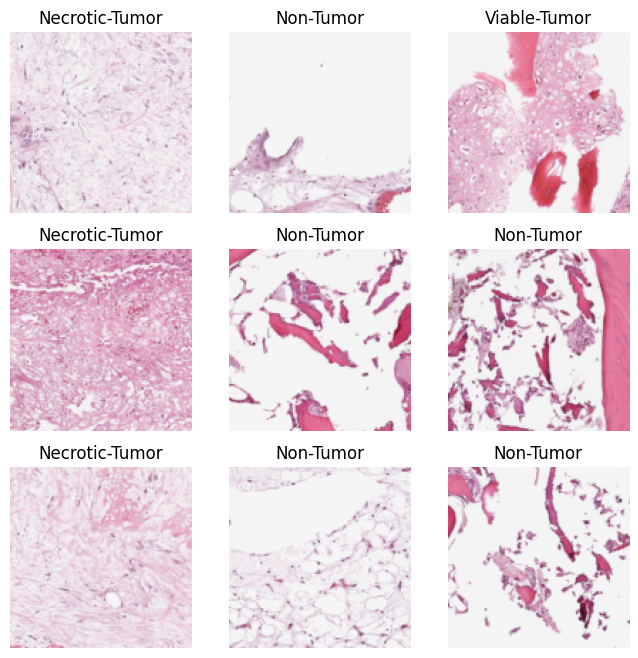

In [ ]:
import torch
from torchvision import datasets, transforms, models
from torchvision.models import EfficientNet_V2_S_Weights
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Definir las transformaciones (pueden ser más ligeras que las de entrenamiento)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Cargar el dataset de test
test_dataset = datasets.ImageFolder(root='../data/osteosarcoma2019/test', transform=transform)

# Configurar la figura para mostrar imágenes
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_dataset), size=(1,)).item()
    img, label = test_dataset[sample_idx]
    
    # Transponer la imagen para que sea compatible con imshow (de (C, H, W) a (H, W, C))
    img = img.permute(1, 2, 0)  # Cambiar de (C, H, W) a (H, W, C)
    
    # Mostrar la imagen
    figure.add_subplot(rows, cols, i)
    plt.title(test_dataset.classes[label])  # Mostrar el nombre de la clase en vez del número
    plt.axis("off")
    plt.imshow(img)  # Mostrar la imagen
plt.show()


In [ ]:
# Definir las transformaciones
transform = EfficientNet_V2_S_Weights.IMAGENET1K_V1.transforms()

# Cargar el dataset de test
test_dataset = datasets.ImageFolder(root='../data/osteosarcoma2019/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Cargar el modelo EfficientNetV2 (de torchvision)
model = models.efficientnet_v2_s(weights=None, num_classes=len(test_dataset.classes))

# Cargar los pesos del modelo entrenado
MODEL_PATH = "../models/efficientnet/osteosarcoma2019/best_model.pth"
model.load_state_dict(torch.load(MODEL_PATH))

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Poner el modelo en modo de evaluación
model.eval()

# Inicializar variables para almacenar las predicciones y las etiquetas
all_preds = []
all_labels = []

# Realizar las predicciones
with torch.no_grad():  # Deshabilitar el cálculo de gradientes para la evaluación
    for imgs, labels in test_loader:
        # Mover los datos a la GPU si es necesario
        imgs, labels = imgs.to(device), labels.to(device)

        # Realizar la predicción
        outputs = model(imgs)  # No es necesario `unsqueeze(0)` porque el DataLoader ya proporciona batches
        _, preds = torch.max(outputs, 1)  # Obtener la clase con mayor probabilidad

        # Almacenar las predicciones y las etiquetas
        all_preds.extend(preds.cpu().numpy())  # Convertir las predicciones a CPU y agregarlas
        all_labels.extend(labels.cpu().numpy())  # Lo mismo para las etiquetas

# Calcular métricas, como la precisión
correct = sum(p == l for p, l in zip(all_preds, all_labels))
accuracy = correct / len(all_labels)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.9100
